# Brazilian Securities

---

### Wilson Freitas


# Brazilian Securities

---

### Wilson Freitas

# Lecture 3


- U.S. Dollar Futures - DOL
    - Dollar curve
- DI x U.S. Dollar Spread Futures - DDI
	- Dirty DI x U.S. Dollar Spread curve
- Forward Rate Agreement on DI x U.S. Dollar Spread - FRC
	- Clean DI x U.S. Dollar Spread curve


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bcb import currency, sgs
import bizdays

MARKET_CALENDAR = bizdays.Calendar.load('ANBIMA.cal')
ACTUAL_CALENDAR = bizdays.Calendar(name='actual')

import myfuncs as my

## U.S. Dollar Futures - DOL

- This trades the future values of exchange rates of Brazilian Reals (BRL) per U.S. Dollar (USD).
    - The exchange rate (PTAX800) variation starting on the *preceding business day* and ending on the business day preceding the maturity.
    - Price quotation is USD 1.000.

- The unit price is defined as

$$
PU_{DOL} = PTAX_{T-1} \cdot 1000
$$

where $PTAX_{T-1}$ is the expected value for the U.S. Dollar exchange rate at maturity.


In [3]:
df = pd.read_parquet('data/contracts_202109_202111.parquet').reset_index(drop=True)

In [4]:
dol = df[(df['Mercadoria'] == 'DOL') &
         (df['DataRef'] == pd.to_datetime('2021-11-01'))].reset_index(drop=True)

In [5]:
dol['Maturity'] = dol['Vencimento'].map(MARKET_CALENDAR.following)
dol['DU'] = list(MARKET_CALENDAR.vec.bizdays(dol['DataRef'], dol['Maturity']))
dol['DC'] = list(ACTUAL_CALENDAR.vec.bizdays(dol['DataRef'], dol['Maturity']))
dol = dol[dol['DU'] > 0].reset_index(drop=True)

In [6]:
dol['PU'] = dol['PUAtual']/1000
dol_curve = dol[['DataRef', 'Maturity', 'DU', 'DC', 'PU']].copy()

In [7]:
dol_curve

,DataRef,Maturity,DU,DC,PU
0,2021-11-01,2021-12-01,20,30,5.700499
1,2021-11-01,2022-01-03,43,63,5.741469
2,2021-11-01,2022-02-01,64,92,5.782576
3,2021-11-01,2022-03-02,83,121,5.826399
4,2021-11-01,2022-04-01,105,151,5.882861
5,2021-11-01,2022-05-02,124,182,5.932744
6,2021-11-01,2022-06-01,146,212,5.994703
7,2021-11-01,2022-07-01,167,242,6.056054
8,2021-11-01,2022-08-01,188,273,6.112162
9,2021-11-01,2022-09-01,211,304,6.175853


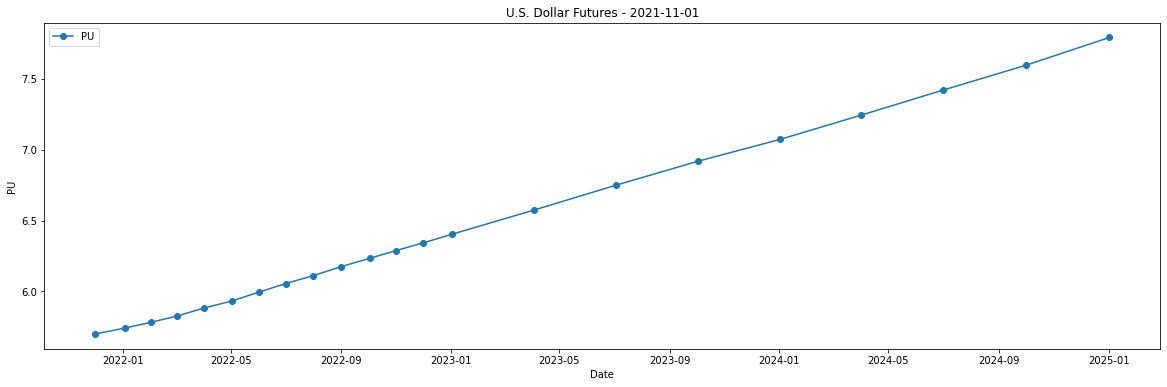

In [8]:
dol_curve.plot(x='Maturity', y='PU', figsize=(20,6), style='-o',
               ylabel='PU', xlabel='Date', title='U.S. Dollar Futures - 2021-11-01');

- We use the current U.S. Dollar exchange rate as the first point of the curve

In [9]:
PTAX = sgs.get(('PTAX', 1), start_date='2021-10-29', end_date='2021-11-01')
PTAX

,PTAX
date,
2021-10-29,5.6430
2021-11-01,5.6694


In [10]:
first_term = pd.DataFrame({
    'DataRef': datetime.datetime(2021,11,1).date(),
    'Maturity': datetime.datetime(2021,11,3).date(),
    'DU': [1],
    'DC': [2],
    'PU': [PTAX.values[1,0]]
})

In [11]:
dol_curve = pd.concat([first_term, dol_curve], axis=0).reset_index(drop=True)

In [12]:
dol_curve.head()

,DataRef,Maturity,DU,DC,PU
0,2021-11-01,2021-11-03,1,2,5.669400
1,2021-11-01,2021-12-01,20,30,5.700499
2,2021-11-01,2022-01-03,43,63,5.741469
3,2021-11-01,2022-02-01,64,92,5.782576
4,2021-11-01,2022-03-02,83,121,5.826399


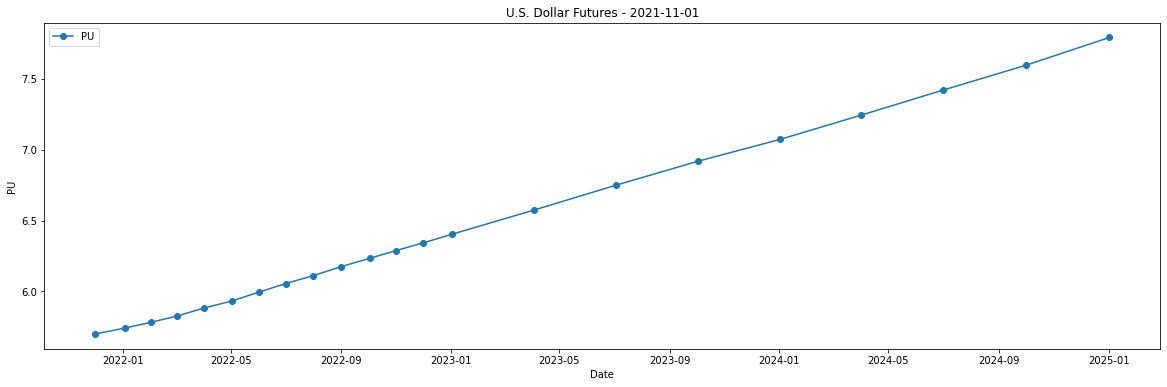

In [13]:
dol.plot(x='Maturity', y='PU', figsize=(20,6), style='-o',
         ylabel='PU', xlabel='Date', title='U.S. Dollar Futures - 2021-11-01');

### Pricing

- From arbitrage theory the future price of U.S. exchance rage can be written as


$$
PTAX_{T-1} = PTAX_{t-1} \frac{( 1 + r(t,T) )^{DU(t,T)/252}}{1 + c(t,T) \cdot \frac{DC(t,T)}{360}}
$$

where

- $t$: current instant of time (reference date)
- $T$: maturity date (date when the contract expires)
- $PTAX_{t-1}$ the exchange rate starting on the business day preceding $t$
- $PTAX_{T-1}$ the exchange rate starting on the business day preceding $T$
- $DC(t,T)$: the total number of days between $t$ e $T$
- $c(t,T)$: spot interest rate between reference date and contract maturity
- $r(t,T)$: risk free interest rate (DI1 Futures rates)


## DI x U.S. Dollar Spread Futures

- This is an interest rate future on the spread between the **interest rate** and **the exchange rate variation**.
- This spread is called **CUPOM CAMBIAL**.
- The future is called **DDI** Future.

### What is CUPOM CAMBIAL?


$$
1 + c(t,T) \cdot \frac{DC(t,T)}{360} = \frac{\Pi_{i=t}^{T}(1 + CDI_i)^{1/252}}{\frac{PTAX_{T-1}}{PTAX_{t-1}}}
$$

- The CUPOM CAMBIAL is calculated from the difference between:
    - the compounded DI rates from an initial date $t$ and up to a date $T$ in the future.
    - the exchange rate variation PTAX800 starting on the business day preceding $t$ and ending on the business day preceding $T$.
- This spread uses simple compounding with current days (360 days per year).


where

- $c(t,T)$ is an exchange interest rate for U.S. Dollar (CUPOM CAMBIAL).
- $DC(t,T)$ is the total number of days between $t$ e $T$.
- $PTAX_{t-1}$ the exchange rate starting on the business day preceding $t$
- $PTAX_{T-1}$ the exchange rate starting on the business day preceding $T$


#### U.S. Dollar Exchange Rate Future Value

- According to Arbitrage Pricing Theory


$$
PTAX_{T-1} = PTAX_{t-1} \frac{( 1 + r(t,T) )^{DU(t,T)/252}}{1 + c(t,T) \cdot \frac{DC(t,T)}{360}}
$$



### Pricing

- The DDI Future is priced as a bullet bond.


$$
PU_{DDI}(t,T) = \frac{100000}{1 + c(t,T) \cdot \frac{DC(t,T)}{360}}
$$

where

- $t$: current instant of time (reference date)
- $T$: maturity date (date when the contract expires)
- $DC(t,T)$: the total number of days between $t$ e $T$
- $c(t,T)$: spot interest rate between reference date and contract maturity





In [14]:
ddi = df[(df['Mercadoria'] == 'DDI') &
         (df['DataRef'] == pd.to_datetime('2021-11-01'))].reset_index(drop=True)

In [15]:
ddi['Maturity'] = ddi['Vencimento'].map(MARKET_CALENDAR.following)
ddi['DC'] = list(ACTUAL_CALENDAR.vec.bizdays(ddi['DataRef'], ddi['Maturity']))
ddi = ddi[ddi['DC'] > 0].reset_index(drop=True)
ddi

,DataRef,Mercadoria,CDVencimento,PUAnterior,PUAtual,Variacao,Vencimento,Maturity,DC
0,2021-11-01,DDI,Z21,99387.51,100428.16,1040.65,2021-12-01,2021-12-01,30
1,2021-11-01,DDI,F22,99313.85,100357.40,1043.55,2022-01-01,2022-01-03,63
2,2021-11-01,DDI,G22,99269.65,100310.70,1041.05,2022-02-01,2022-02-01,92
3,2021-11-01,DDI,H22,99206.95,100248.33,1041.38,2022-03-01,2022-03-02,121
4,2021-11-01,DDI,J22,99127.65,100168.90,1041.25,2022-04-01,2022-04-01,151
5,2021-11-01,DDI,K22,99053.14,100094.12,1040.98,2022-05-01,2022-05-02,182
6,2021-11-01,DDI,M22,98961.99,99993.52,1031.53,2022-06-01,2022-06-01,212
7,2021-11-01,DDI,N22,98921.32,99951.62,1030.30,2022-07-01,2022-07-01,242
8,2021-11-01,DDI,Q22,98774.23,99794.91,1020.68,2022-08-01,2022-08-01,273
9,2021-11-01,DDI,U22,98658.94,99676.78,1017.84,2022-09-01,2022-09-01,304


$$
c(t,T) = \left( \frac{100000}{PU_{DDI}(t,T)} - 1 \right) \cdot \frac{360}{DC(t,T)}
$$

In [16]:
ddi['Rate'] = (100000 / ddi['PUAtual'] - 1)*(360 / ddi['DC'])
ddi_curve = ddi[['DataRef', 'Maturity', 'DC', 'Rate']]

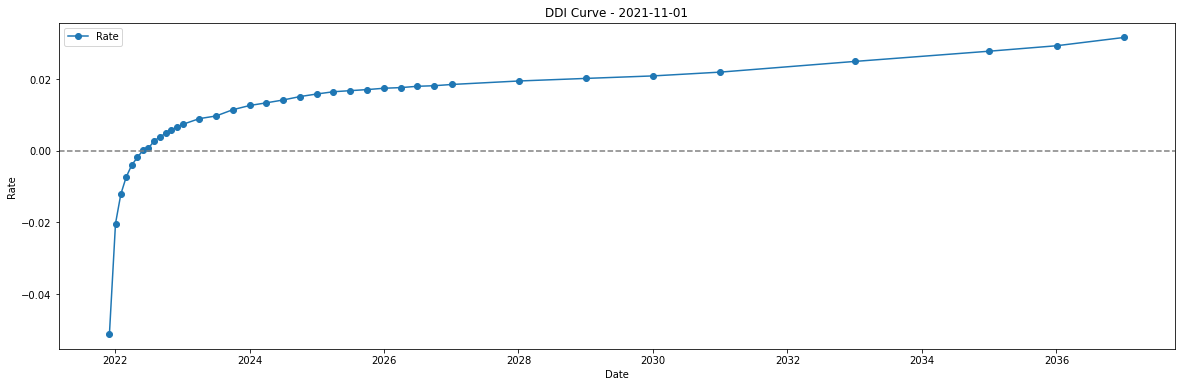

In [17]:
ddi_curve.plot(x='Maturity', y='Rate', figsize=(20,6), style='-o',
               ylabel='Rate', xlabel='Date', title='DDI Curve - 2021-11-01')
plt.axhline(y=0, ls='--', color='grey')
plt.show()

- The curve starts with the first future, which matures in December.

In [18]:
ddi_curve.head()

,DataRef,Maturity,DC,Rate
0,2021-11-01,2021-12-01,30,-0.05116
1,2021-11-01,2022-01-03,63,-0.02035
2,2021-11-01,2022-02-01,92,-0.01212
3,2021-11-01,2022-03-02,121,-0.00737
4,2021-11-01,2022-04-01,151,-0.00402


- We must complete the curve with the first point for one business day

### Completing the curve with the first point (the anchor)

- Calculate the CUPOM CAMBIAL for one business day ahead

$$
1 + c(t,t+1) \cdot \frac{DC(t,t+1)}{360} = \frac{(1 + CDI_t)^{DU(t,t+1)/252}}{\frac{PTAX_{t}}{PTAX_{t-1}}}
$$

- $t$ is the current day, the present
- $t+1$ is one business day ahead and $t-1$ reffers to the previous business day
- $DU(t,t+1) = 1$

In [19]:
PTAX

,PTAX
date,
2021-10-29,5.6430
2021-11-01,5.6694


In [20]:
CDI = sgs.get(('CDI', 4389), start_date='2021-11-01', end_date='2021-11-01')
CDI

,CDI
date,
2021-11-01,7.65


$$
c(t,t+1) = \left( \frac{(1 + CDI_t)^{1/252}}{\frac{PTAX_{t}}{PTAX_{t-1}}} - 1 \right)\frac{360}{DC(t,t+1)}
$$

In [21]:
cdi = CDI.values[0,0]
ptax_0 = PTAX.values[1,0] # PTAX(t) for the current business day
ptax_1 = PTAX.values[0,0] # PTAX(t-1) for the previous business day
DC = 2 # total number of days between the reference date and one business day ahead

first_term = pd.DataFrame({
    'DataRef': datetime.datetime(2021,11,1).date(),
    'Maturity': datetime.datetime(2021,11,3).date(),
    'DC': [DC],
    'Rate': [(((1 + cdi/100)**(1/252)) / (ptax_0/ptax_1) - 1) * 360/DC]
})

In [22]:
ddi_curve = pd.concat([first_term, ddi_curve], axis=0).reset_index(drop=True)

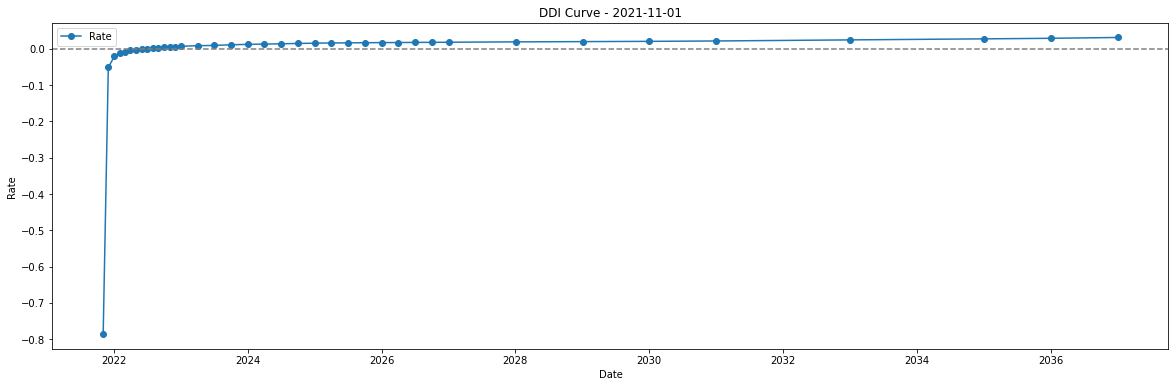

In [23]:
ddi_curve.plot(x='Maturity', y='Rate', figsize=(20,6), style='-o',
               ylabel='Rate', xlabel='Date', title='DDI Curve - 2021-11-01')
plt.axhline(y=0, ls='--', color='grey')
plt.show()

- This is the DDI Dirty Curve (Curva de CUPOM CAMBIAL SUJA)

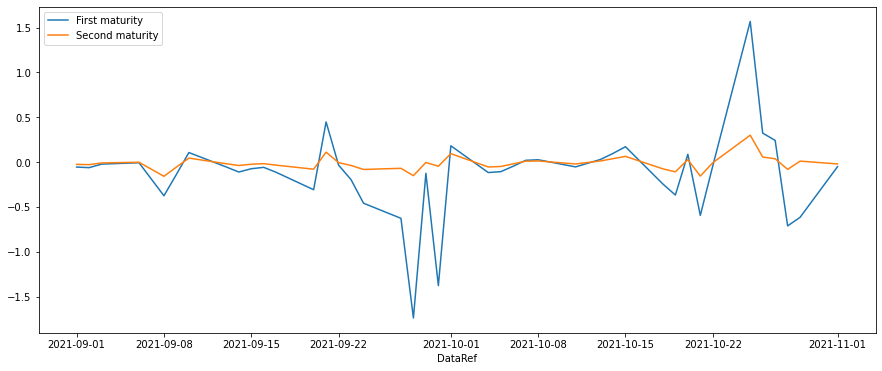

In [24]:
ddi_hist = df[(df['Mercadoria'] == 'DDI') & (df['PUAtual'] != 100000.0)].copy()
ddi_hist['VencimentoAdj'] = ddi_hist['Vencimento'].map(MARKET_CALENDAR.following)
ddi_hist['DU'] = list(MARKET_CALENDAR.vec.bizdays(ddi_hist['DataRef'], ddi_hist['VencimentoAdj']))
ddi_hist['DC'] = list(ACTUAL_CALENDAR.vec.bizdays(ddi_hist['DataRef'], ddi_hist['VencimentoAdj']))
ddi_hist['Taxa'] = (100000 / ddi_hist['PUAtual'] - 1)/(ddi_hist['DC'] / 360)
ddi_hist_first = ddi_hist.groupby('DataRef').apply(lambda x: x.sort_values('DU').iloc[0])
ddi_hist_m1 = ddi_hist_first.set_index('DataRef')['Taxa']
ddi_hist_second = ddi_hist.groupby('DataRef').apply(lambda x: x.sort_values('DU').iloc[1])
ddi_hist_m2 = ddi_hist_second.set_index('DataRef')['Taxa']
ddi_hist_x = pd.concat((ddi_hist_m1, ddi_hist_m2), axis=1)
ddi_hist_x.columns = ('First maturity', 'Second maturity')
ddi_hist_x.plot(figsize=(15,6));

### Why DIRTY CUPOM CAMBIAL?

#### Variability of CUPOM CAMBIAL

![](images/cupom-sujo-primeiro-vencimento-historico.png)

### Why DIRTY CUPOM CAMBIAL?

$$
\frac{PTAX_{t}}{PTAX_{t-1}} = \frac{(1 + CDI_t)^{DU(t,t+1)/252}}{1 + c(t,t+1) \cdot \frac{DC(t,t+1)}{360}}
$$

- What does happen when it goes from $t \rightarrow T$?

$$
\frac{PTAX_{T-1}}{PTAX_{t-1}} = \frac{(1 + CDI(t,T))^{DU(t,T)/252}}{1 + c(t,T) \cdot \frac{DC(t,T)}{360}}
$$

- The residual effect of the *shift* in the exchange rate goes to the only available parameter, that is $c(\cdot)$.

#### Solution

- **Dólar CUPOM LIMPO**

### Dólar Cupom Limpo

- Dólar Cupom Limpo *cleans* the DDI curve removing the effect of the 1-day dollar return.
- Dólar Cupom Limpo is obtained from Casado de Dólar.
    - Casado de Dólar is an strututured product
- Dólar Cupom Limpo is a U.S. Dollar exhange rate traded in the market with settlement in two business days (d+2).

$$
PTAX_{t} = PTAX_{t-1} \frac{(1 + CDI_t)^{DU(t,t+1)/252}}{1 + CS(t,t+1) \cdot \frac{DC(t,t+1)}{360}}
$$

and

$$
PTAX_{t} = DOCL_{t} \frac{(1 + CDI_t)^{DU(t,t+1)/252}}{1 + CL(t,t+1) \cdot \frac{DC(t,t+1)}{360}}
$$

where

- $CS(t,t+1)$ stands for CUPOM SUJO
- $CL(t,t+1)$ stands for CUPOM LIMPO

$$
\frac{DOCL_{t}}{1 + CL(t,t+1) \cdot \frac{DC(t,t+1)}{360}} = \frac{PTAX_{t-1}}{1 + CS(t,t+1) \cdot \frac{DC(t,t+1)}{360}}
$$



- B3 informs daily

![](images/dolar-cupom-limpo-casado.png)

## Forward Rate Agreement on DI x U.S. Dollar Spread - FRC

- This future trades the forward DI x U.S. Dollar Spread Rate from the expiration date of the short DI x U.S. Dollar Spread Futures (short leg - first maturity) to the expiration date of long DI x U.S. Dollar Spread Futures (long leg).
- This future is called **FRC** Future.
- Since two contracts are traded, the quotation is defined in terms of the forward rate

$$
1 + c_{FRC}(T_s, T_l) \cdot \frac{DC(t,T_l)-DC(t,T_s)}{360} = \frac{1 + c(t, T_l) \cdot \frac{DC(t,T_l)}{360}}{1 + c(t, T_s) \cdot \frac{DC(t,T_s)}{360}}
$$


In [25]:
frc = df[(df['Mercadoria'] == 'FRC') &
         (df['DataRef'] == pd.to_datetime('2021-11-01'))].copy()

In [26]:
frc['Maturity'] = frc['Vencimento'].map(MARKET_CALENDAR.following)
frc['DU'] = frc.apply(lambda x: MARKET_CALENDAR.bizdays(x['DataRef'], x['Maturity']), axis=1)
frc['DC'] = frc.apply(lambda x: ACTUAL_CALENDAR.bizdays(x['DataRef'], x['Maturity']), axis=1)
frc = frc[frc['DU'] > 0].reset_index(drop=True)

In [27]:
frc.head()

,DataRef,Mercadoria,CDVencimento,PUAnterior,PUAtual,Variacao,Vencimento,Maturity,DU,DC
0,2021-11-01,FRC,F22,0.81,0.77,-0.04,2022-01-01,2022-01-03,43,63
1,2021-11-01,FRC,G22,0.69,0.68,-0.01,2022-02-01,2022-02-01,64,92
2,2021-11-01,FRC,H22,0.72,0.71,-0.01,2022-03-01,2022-03-02,83,121
3,2021-11-01,FRC,J22,0.78,0.77,-0.01,2022-04-01,2022-04-01,105,151
4,2021-11-01,FRC,K22,0.80,0.79,-0.01,2022-05-01,2022-05-02,124,182


- Let's use Dólar CUPOM LIMPO with the first future to build the term structure for CUPOM CAMBIAL LIMPO

$$
\left( 1 + CL(t, T_s) \cdot \frac{DC(t,T_s)}{360} \right)  \left( 1 + c_{FRC}(T_s, T_l) \cdot \frac{DC(t,T_l)-DC(t,T_s)}{360}\right) =  1 + c(t, T_l) \cdot \frac{DC(t,T_l)}{360} 
$$

- considering that

$$
1 + CL(t,T_s) \cdot \frac{DC(t,T_s)}{360} = \frac{DOCL_{t}}{PTAX_{t-1}} \left(1 + CS(t,T_s) \cdot \frac{DC(t,T_s)}{360} \right)
$$


In [28]:
dol_cl = 5.6699
ptax_1 = PTAX.values[0,0] # PTAX(t-1) for the previous business day
cs = ddi_curve['Rate'].iloc[1] # CUPOM CAMBIAL SUJO for the first future
dc = ddi_curve['DC'].iloc[1]

_f_cl = (dol_cl/ptax_1) * (1 + cs*dc/360)


- B3 informs daily

![](images/dolar-cupom-limpo-casado.png)

$$
CL(t,T_l) = \left[ \left( 1 + CL(t, T_s) \frac{DC(t,T_s)}{360} \right) \left( 1 + c_{FRC}(T_s, T_l) \frac{DC(t,T_l)-DC(t,T_s)}{360}\right) - 1\right]\frac{360}{DC(t,T_l)}
$$


In [29]:
_frc = (1 + (frc['PUAtual']/100)*((frc['DC'] - dc)/360))
frc['Rate'] = (_f_cl * _frc - 1) * (360/frc['DC'])
frc.head()

,DataRef,Mercadoria,CDVencimento,PUAnterior,PUAtual,Variacao,Vencimento,Maturity,DU,DC,Rate
0,2021-11-01,FRC,F22,0.81,0.77,-0.04,2022-01-01,2022-01-03,43,63,0.006797
1,2021-11-01,FRC,G22,0.69,0.68,-0.01,2022-02-01,2022-02-01,64,92,0.006476
2,2021-11-01,FRC,H22,0.72,0.71,-0.01,2022-03-01,2022-03-02,83,121,0.006780
3,2021-11-01,FRC,J22,0.78,0.77,-0.01,2022-04-01,2022-04-01,105,151,0.007325
4,2021-11-01,FRC,K22,0.80,0.79,-0.01,2022-05-01,2022-05-02,124,182,0.007557


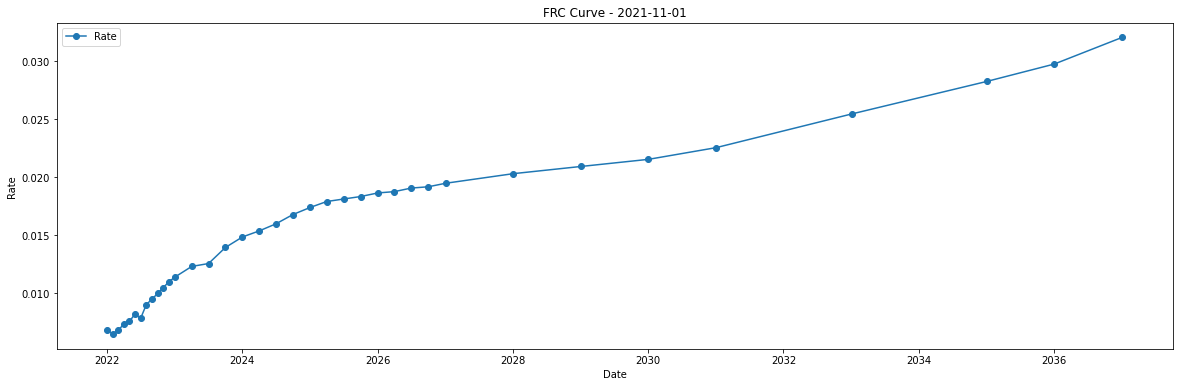

In [30]:
frc_curve = frc[['DataRef', 'Maturity', 'DC', 'Rate']].copy()
frc_curve.plot(x='Maturity', y='Rate', figsize=(20,6), style='-o',
               ylabel='Rate', xlabel='Date', title='FRC Curve - 2021-11-01')
plt.show()